In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics as sts
from lammps import lammps as lmp
from sklearn.linear_model import LinearRegression
from scipy.constants import h, c, k as kB, R

In [2]:

lj_dir = "/Users/harlevido/Desktop/Masters/project/lj/Data/"
mie_dir = "/Users/harlevido/Desktop/Masters/project/mie/Data/"

#__________________________________________
# Nist Data read
_100Mpa = pd.read_excel('/Users/harlevido/Desktop/Masters/project/100Mpa.xlsx')
_70Mpa = pd.read_excel('/Users/harlevido/Desktop/Masters/project/70Mpa.xlsx')
_40Mpa = pd.read_excel('/Users/harlevido/Desktop/Masters/project/40Mpa.xlsx')
_10Mpa = pd.read_excel('/Users/harlevido/Desktop/Masters/project/10Mpa.xlsx')

#________________________________________
#constants
kb = 1.3807*pow(10,-23) #[J/K]
sigmalj = 2.96 * pow(10,-10) #[Meters]
sigmami = 3.1586 * pow(10,-10) #[Meters]
m = 1.67335 * pow(10,-27) #[Kg]
epsilonlj = 34.2 * kb
epsilonmie = 18.355 * kb

taulj = pow(m*pow(sigmalj,2)/epsilonlj,1/2)   #[Sec]
taumie = pow(m*pow(sigmami,2)/epsilonmie,1/2)
N = 2*512
mole = 6.022*pow(10,23)



In [3]:

def mean(zn,data,var1):
    var = list()
    for k in range(0, 4):
        tempdf = []
        for j in range(len(data[k])):
            temp = 0
            for i in range(len(data[k][j])):
                row = (data[k][j].iloc[i])
                zn1 = np.exp(-(row['energy']) / (kb*row['temp'])) * np.exp(
                    -(row['press']) * (row['volume']) / (kb*row['temp']))
                temp += row[var1]*zn1 /zn[k][j]
            tempdf.append(temp)
        var.append(tempdf)
    return var
def mean2(zn,data,var1,var2):
    var = list()
    for k in range(0, 4):
        tempdf = []
        for j in range(len(data[k])):
            temp = 0
            for i in range(len(data[k][j])):
                row = (data[k][j].iloc[i])
                zn1 = np.exp(-(row['energy']) / (kb*row['temp'])) * np.exp(
                    -(row['press']) * (row['volume']) / (kb*row['temp']))
                temp += row[var2]*row[var1] * zn1 / zn[k][j]
            tempdf.append(temp)
        var.append(tempdf)
    return var


def regmean(data,var1):
    var = list()
    for k in range(0, 4):
        tempdf = []
        for j in range(len(data[k])):
            tempdf.append(data[k][j][var1].mean())
        var.append(tempdf)
    return var
def regmean2(data,var1,var2):
    var = list()
    for k in range(0, 4):
        tempdf = []
        for j in range(len(data[k])):
            tempdf.append(np.multiply(data[k][j][var1],data[k][j][var2]).mean())
        var.append(tempdf)
    return var




In [4]:

## collecting the data
ljdata = list()
miedata = list()
Ps = [10,40,70,100]
for j in Ps:
    tempdf = []
    for i in range(100,450,50):
        addr = lj_dir  + f"{i}" +"K_" + f"{j}" + 'Mpa/mydata-lj.' + f'{i}' + "K_" + f'{j}' + 'Mpa'
        temp = pd.read_json(addr,lines=True)
        tempdf.append(temp)
    ljdata.append(tempdf)

for j in Ps:
    tempdf = []
    for i in range(100,450,50):
        addr = mie_dir  + f"{i}" +"K_" + f"{j}" + 'Mpa/mydata-mie.' + f'{i}' + "K_" + f'{j}' + 'Mpa'
        temp = pd.read_json(addr,lines=True)
        tempdf.append(temp)
    miedata.append(tempdf)
#----------------------------

In [5]:
'''
##return to real units:
#for lj data
for j in range(0,4):
    for i in range(len(ljdata[j])):
        ljdata[j][i]['temp'] = ljdata[j][i]['temp']*epsilonlj/kb
        ljdata[j][i]['volume']= ljdata[j][i]['volume']*pow(sigmalj,3)
        ljdata[j][i]['energy'] = ljdata[j][i]['energy']*epsilonlj
        ljdata[j][i]['press'] = ljdata[j][i]['press'] * epsilonlj/(pow(sigmalj,3))
        #ljdata[j][i]['enthalpy'] = (ljdata[j][i]['energy'] + ljdata[j][i]['volume']*ljdata[j][i]['press']) * epsilonlj
        ljdata[j][i]['enthalpy'] = ljdata[j][i]['enthalpy'] * epsilonlj *mole/N
'''
#for mie data
ljsi = ljdata.copy()
miesi = miedata.copy()
for j in range(0,4):
    for i in range(len(miedata[j])):

        #ljdata[j][i]['enthalpy'] = ljdata[j][i]['enthalpy']/N
        #miedata[j][i]['enthalpy'] = miedata[j][i]['enthalpy'] * epsilonmie/(epsilonlj*N)

        # ------- Mie to LJ
        '''
        miedata[j][i]['enthalpy'] =(miedata[j][i]['EP'] + miedata[j][i]['volume'] * miedata[j][i]['press']) * epsilonmie/(epsilonlj*N)
        ljdata[j][i]['enthalpy'] = (ljdata[j][i]['EP'] + ljdata[j][i]['volume'] * ljdata[j][i]['press']) / N
        miedata[j][i]['temp'] = miedata[j][i]['temp'] * epsilonmie / epsilonlj
        miedata[j][i]['volume'] = miedata[j][i]['volume'] / pow(sigmalj, 3) * pow(sigmami, 3)
        miedata[j][i]['energy'] = miedata[j][i]['energy'] * epsilonmie / epsilonlj
        miedata[j][i]['press'] = miedata[j][i]['press'] * pow(sigmami, 3) / pow(sigmalj, 3)
        miedata[j][i]['press'] = miedata[j][i]['press'] * pow(sigmami, 3) / pow(sigmalj, 3)
        '''
        # both data in SI
        miesi[j][i]['press'] = miesi[j][i]['press'] *epsilonmie / pow(sigmami, 3)
        ljsi[j][i]['press'] = ljsi[j][i]['press'] * epsilonlj / pow(sigmalj, 3)
        miesi[j][i]['volume'] = miesi[j][i]['volume'] * pow(sigmami, 3) / (N*m)
        ljsi[j][i]['volume'] = ljsi[j][i]['volume']* pow(sigmalj, 3) / (N*m)
        miesi[j][i]['temp'] = miesi[j][i]['temp'] * epsilonmie / kb
        ljsi[j][i]['temp'] = ljsi[j][i]['temp'] * epsilonlj / kb
        miesi[j][i]['energy'] = miesi[j][i]['energy']* epsilonmie / (m)
        ljsi[j][i]['energy'] = ljsi[j][i]['energy'] * epsilonlj / (m)
        miesi[j][i]['EP'] = miesi[j][i]['EP']* epsilonmie / (m)
        ljsi[j][i]['EP'] = ljsi[j][i]['EP']* epsilonlj / (m)
        miesi[j][i]['Ek'] = miesi[j][i]['Ek'] * epsilonmie / (m)
        ljsi[j][i]['Ek'] = ljsi[j][i]['Ek'] * epsilonlj / (m)

        '''
        ljsi[j][i]['real enthalpy'] = 2*ljsi[j][i]['Ek'] + ljsi[j][i]['EP'] + ljsi[j][i]['press']*ljsi[j][i]['volume']
        miesi[j][i]['real enthalpy'] = 2*miesi[j][i]['Ek'] + miesi[j][i]['EP'] + miesi[j][i]['press'] * miesi[j][i]['volume']


        ljsi[j][i]['enthalpy'] = ljsi[j][i]['EP'] + ljsi[j][i]['press'] * ljsi[j][i]['volume']
        miesi[j][i]['enthalpy'] = miesi[j][i]['EP'] + miesi[j][i]['press'] * miesi[j][i]['volume']
        print(ljsi[j][i])
        '''

        ljsi[j][i]['real enthalpy'] = ljsi[j][i]['enthalpy']*epsilonlj / m + ljsi[j][i]['Ek']/2 #- ljsi[j][i]['EP']
        miesi[j][i]['real enthalpy'] = miesi[j][i]['enthalpy'] * epsilonmie / m + miesi[j][i]['Ek']/2 #- 2*miesi[j][i]['EP']

        ljsi[j][i]['enthalpy'] = ljsi[j][i]['real enthalpy'] - 2*ljsi[j][i]['Ek']
        miesi[j][i]['enthalpy'] = miesi[j][i]['real enthalpy'] - 2*miesi[j][i]['Ek']


#-----------------------



In [6]:

'''
#calculate zn:
znlj = list()
znmie= list()

#for lj:
for k in range(0,4):
    tempdf = []
    for j in range(len(ljdata[k])):
        temp = 0
        for i in range(len(ljdata[k][j])):
            row = (ljdata[k][j].iloc[i])
            beta = 1/(kb*row['temp'])
            temp += np.exp(-row['energy']*beta) * np.exp(-(row['press']) * (row['volume'])*beta)
        tempdf.append(temp)
    znlj.append(tempdf)


#for mie:
for k in range(0,4):
    tempdf = []
    for j in range(len(miedata[k])):
        temp = 0
        for i in range(len(miedata[k][j])):
            row = (miedata[k][j].iloc[i])
            beta = 1/(kb*row['temp'])
            temp += np.exp(-row['energy']*beta) * np.exp(-(row['press']) * (row['volume'])*beta)
        tempdf.append(temp)
    znmie.append(tempdf)
'''
#-----------------------------------




"\n#calculate zn:\nznlj = list()\nznmie= list()\n\n#for lj:\nfor k in range(0,4):\n    tempdf = []\n    for j in range(len(ljdata[k])):\n        temp = 0\n        for i in range(len(ljdata[k][j])):\n            row = (ljdata[k][j].iloc[i])\n            beta = 1/(kb*row['temp'])\n            temp += np.exp(-row['energy']*beta) * np.exp(-(row['press']) * (row['volume'])*beta)\n        tempdf.append(temp)\n    znlj.append(tempdf)\n\n\n#for mie:\nfor k in range(0,4):\n    tempdf = []\n    for j in range(len(miedata[k])):\n        temp = 0\n        for i in range(len(miedata[k][j])):\n            row = (miedata[k][j].iloc[i])\n            beta = 1/(kb*row['temp'])\n            temp += np.exp(-row['energy']*beta) * np.exp(-(row['press']) * (row['volume'])*beta)\n        tempdf.append(temp)\n    znmie.append(tempdf)\n"

In [7]:

#thermodynamics:
###calculating thermodynamics: lj

vol = regmean(ljsi,'volume')
h = regmean(ljsi,'enthalpy')
hr = regmean(ljsi,'real enthalpy')
E = regmean(ljsi,'EP')
T = regmean(ljsi,'temp')
p = regmean(ljsi, 'press')

hv = regmean2(ljsi,'enthalpy','volume')
hvr = regmean2(ljsi,'real enthalpy','volume')
#hv = mean2(znlj,ljdata,'enthalpy','volume')
vv = regmean2(ljsi,'volume','volume')
hE = regmean2(ljsi,'real enthalpy','energy')

###calculating thermodynamics: mie

volm = regmean(miesi,'volume')
hm = regmean(miesi,'real enthalpy')
hmr = regmean(miesi,'real enthalpy')
Em = regmean(miesi,'EP')
Tm = regmean(miesi,'temp')
pm = regmean(miesi, 'press')

hvm = regmean2(miesi,'real enthalpy','volume')
hvmr = regmean2(miesi,'real enthalpy','volume')
#hv = mean2(znlj,ljdata,'enthalpy','volume')
vvm = regmean2(miesi,'volume','volume')
hEm = regmean2(miesi,'real enthalpy','energy')



In [8]:

#calculate alpha
alpha = list()
alpham = list()
Tmean = [100,150,200,250,300,350,400]

for i in range(4):
    temp = np.divide(np.subtract(hv[i],np.multiply(vol[i],h[i])),np.multiply(vol[i],np.multiply(Tmean,Tmean)))
    alpha.append(abs(temp))
    temp = np.divide(np.subtract(hvm[i],np.multiply(volm[i],hm[i])),np.multiply(volm[i],np.multiply(Tmean,Tmean)))
    alpham.append(abs(temp))


#calculate kt
kt = list()
ktm = list()
for i in range(4):
    temp = np.divide(np.subtract(vv[i],np.multiply(vol[i],vol[i])),[x *kb/(N*m* pow(10,6)) for x in np.multiply(vol[i],Tmean)])
    #temp = np.divide(np.subtract(vv[i],np.multiply(vol[i],vol[i])),np.multiply(vol[i],np.multiply(Tmean,Tmean)))
    kt.append(temp)
    temp = np.divide(np.subtract(vvm[i], np.multiply(volm[i], volm[i])),
                     [x * kb / (N * m * pow(10, 6)) for x in np.multiply(volm[i], Tmean)])
    ktm.append(temp)

#calculate Cp
cp = list()
cpm = list()
for i in range(4):
    temp = 2*np.divide(np.subtract(hEm[i],np.multiply(hm[i],Em[i])),[x * kb*2/ (m) for x in np.multiply(Tmean,Tmean)]) + np.multiply(np.divide(np.subtract(hvm[i],np.multiply(hm[i],volm[i])),[x * kb*2/ (m)  for x in np.multiply(Tmean,Tmean)]),pm[i]) - 2*kb/m
    cpm.append(temp)
    temp = 2*np.divide(np.subtract(hE[i],np.multiply(h[i],E[i])),[x * kb*2/ (m) for x in np.multiply(Tmean,Tmean)]) + np.multiply(np.divide(np.subtract(hv[i],np.multiply(h[i],vol[i])),[x * kb*2/ (m)  for x in np.multiply(Tmean,Tmean)]),p[i]) - 2*kb/m
    cp.append(temp)

    #   sts.mean(p[i])


#calculating density
rho = list()
rhom = list()
for i in range(4):
    tempdf = []
    for j in vol[i]:
        tempdf.append(1/j)
    rho.append(tempdf)
for i in range(4):
    tempdf = []
    for j in volm[i]:
        tempdf.append(1/j)
    rhom.append(tempdf)

### i have a problem here
#calculate Cv
cv = list()
cvm = list()
for i in range(4):
    temp = np.subtract(cp[i],np.divide(np.multiply(np.multiply(T[i],vol[i]),np.multiply(alpha[i],alpha[i])),kt[i])*m)
    cv.append(temp)
    temp = np.subtract(cpm[i], np.divide(np.multiply(np.multiply(Tm[i], volm[i]), np.multiply(alpham[i], alpham[i])), ktm[i])*m)
    cvm.append(temp)
    #   sts.mean(p[i])


#calculating speed of sound:
vs = list()
vsm = list()
for i in range(4):
    temp = np.sqrt(np.divide(cp[i], np.multiply(np.multiply(cv[i], kt[i]), rho[i])))
    vs.append(temp)
    temp = np.sqrt(np.divide(cpm[i], np.multiply(np.multiply(cvm[i], ktm[i]), rhom[i])))
    vsm.append(temp)



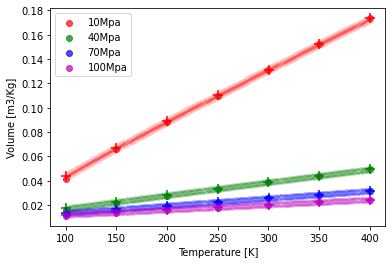

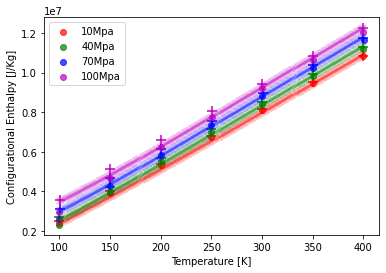

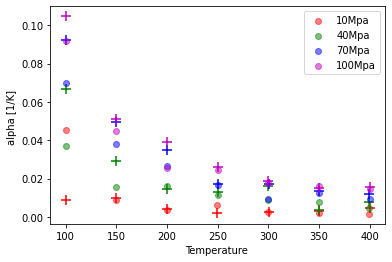

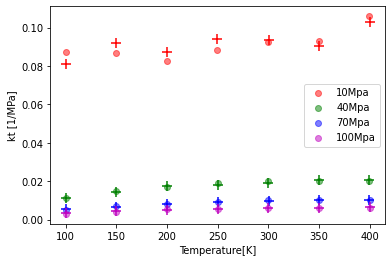

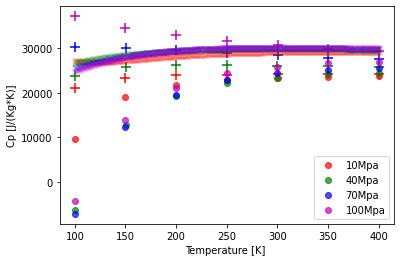

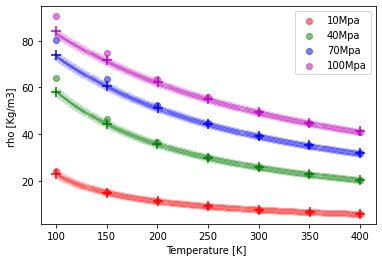

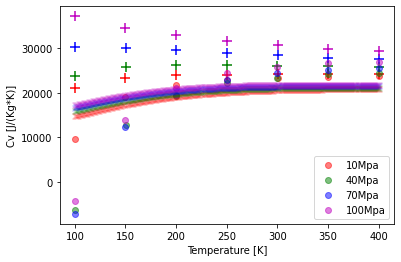

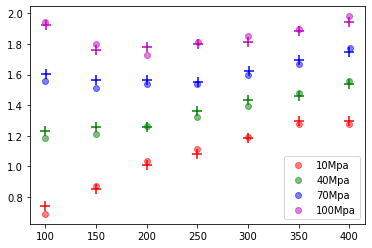

In [9]:

## plots:
colors = ['r', 'g' , 'b' , 'm']
Press = ['10Mpa','40Mpa','70Mpa','100Mpa']



for i in range(4):
    plt.scatter(T[i],vol[i],color = colors[i], marker = 'o',label = Press[i], alpha = 0.7)
    plt.legend()
    plt.scatter(Tm[i], volm[i], color=colors[i], marker='+', s = 100)
plt.scatter(_10Mpa['Temperature (K)'], _10Mpa['Volume (m3/kg)'], color='r', marker='x', alpha=0.2)
plt.scatter(_40Mpa['Temperature (K)'], _40Mpa['Volume (m3/kg)'], color='g', marker='x', alpha=0.2)
plt.scatter(_70Mpa['Temperature (K)'], _70Mpa['Volume (m3/kg)'], color='b', marker='x', alpha=0.2)
plt.scatter(_100Mpa['Temperature (K)'], _100Mpa['Volume (m3/kg)'], color='m', marker='x', alpha=0.2)
plt.xlabel('Temperature [K]')
plt.ylabel('Volume [m3/Kg]')
#
plt.show()

for i in range(4):
    plt.scatter(T[i], hr[i],label = Press[i],color = colors[i], marker = 'o',alpha = 0.7)
    plt.legend()
    plt.scatter(Tm[i],  hmr[i],color = colors[i], marker = '+',s = 100)

plt.scatter(_10Mpa['Temperature (K)'], _10Mpa['Enthalpy (kJ/mol)']*1000/(m*mole), color='r', marker='x', alpha=0.2)
plt.scatter(_40Mpa['Temperature (K)'], _40Mpa['Enthalpy (kJ/mol)']*1000/(m*mole), color='g', marker='x', alpha=0.2)
plt.scatter(_70Mpa['Temperature (K)'], _70Mpa['Enthalpy (kJ/mol)']*1000/(m*mole), color='b', marker='x', alpha=0.2)
plt.scatter(_100Mpa['Temperature (K)'], _100Mpa['Enthalpy (kJ/mol)']*1000/(m*mole), color='m', marker='x', alpha=0.2)
plt.xlabel('Temperature [K]')
plt.ylabel('Configurational Enthalpy [J/Kg]')

plt.show()

for i in range(4):
    plt.scatter(T[i], alpha[i],color = colors[i],label = Press[i], marker = 'o',alpha = 0.5)
    plt.legend()
    plt.scatter(Tm[i], alpham[i],color = colors[i], marker = '+', s = 100)
    plt.xlabel('Temperature ')
    plt.ylabel('alpha [1/K] ')
plt.show()

for i in range(4):
    plt.scatter(T[i], kt[i],color = colors[i],label = Press[i], marker = 'o',alpha = 0.5)
    plt.legend()
    plt.scatter(Tm[i], ktm[i],color = colors[i], marker = '+',s = 100)
plt.xlabel('Temperature[K]')
plt.ylabel('kt [1/MPa]')
plt.show()


for i in range(4):
    plt.scatter(T[i],cp[i],label = Press[i],color = colors[i], marker = 'o', alpha = 0.7)
    plt.legend()
    plt.scatter(Tm[i], cpm[i], color = colors[i], marker = '+',s = 100)

plt.scatter(_10Mpa['Temperature (K)'],_10Mpa['Cp (J/mol*K)']/(m*mole),color = 'r', marker = 'x', alpha = 0.2)
plt.scatter(_40Mpa['Temperature (K)'],_40Mpa['Cp (J/mol*K)']/(m*mole),color = 'g', marker = 'x', alpha = 0.2)
plt.scatter(_70Mpa['Temperature (K)'],_70Mpa['Cp (J/mol*K)']/(m*mole),color = 'b', marker = 'x', alpha = 0.2)
plt.scatter(_100Mpa['Temperature (K)'],_100Mpa['Cp (J/mol*K)']/(m*mole),color = 'm', marker = 'x', alpha = 0.2)

plt.xlabel('Temperature [K] ')
plt.ylabel('Cp [J/(Kg*K)]')
plt.show()


for i in range(4):
    plt.scatter(T[i], rho[i], color = colors[i],label = Press[i] ,marker = 'o',alpha = 0.5)
    plt.legend()
    plt.scatter(Tm[i], rhom[i],color = colors[i], marker = '+',s = 100)
plt.scatter(_10Mpa['Temperature (K)'],_10Mpa['Density (kg/m3)'],color = 'r', marker = 'x', alpha = 0.2)
plt.scatter(_40Mpa['Temperature (K)'],_40Mpa['Density (kg/m3)'],color = 'g', marker = 'x', alpha = 0.2)
plt.scatter(_70Mpa['Temperature (K)'],_70Mpa['Density (kg/m3)'],color = 'b', marker = 'x', alpha = 0.2)
plt.scatter(_100Mpa['Temperature (K)'],_100Mpa['Density (kg/m3)'],color = 'm', marker = 'x', alpha = 0.2)
plt.xlabel('Temperature [K] ')
plt.ylabel('rho [Kg/m3] ')
plt.show()

for i in range(4):
    plt.scatter(T[i], cv[i], color = colors[i],label = Press[i], marker = 'o',alpha = 0.5)
    plt.legend()
    plt.scatter(Tm[i], cvm[i],color = colors[i], marker = '+',s = 100)
plt.scatter(_10Mpa['Temperature (K)'],_10Mpa['Cv (J/mol*K)']/(m*mole),color = 'r', marker = 'x', alpha = 0.2)
plt.scatter(_40Mpa['Temperature (K)'],_40Mpa['Cv (J/mol*K)']/(m*mole),color = 'g', marker = 'x', alpha = 0.2)
plt.scatter(_70Mpa['Temperature (K)'],_70Mpa['Cv (J/mol*K)']/(m*mole),color = 'b', marker = 'x', alpha = 0.2)
plt.scatter(_100Mpa['Temperature (K)'],_100Mpa['Cv (J/mol*K)'] /(m*mole) ,color = 'm', marker = 'x', alpha = 0.2)
plt.xlabel('Temperature [K]')
plt.ylabel('Cv [J/(Kg*K)]')
plt.show()



for i in range(4):
    plt.scatter(T[i], vs[i], color = colors[i],label = Press[i], marker = 'o',alpha = 0.5)
    plt.legend()
    plt.scatter(Tm[i], vsm[i],color = colors[i], marker = '+',s = 100)
'''
plt.scatter(_10Mpa['Temperature (K)'],_10Mpa['Sound Spd. (m/s)'],color = 'r', marker = 'x', alpha = 0.2)
plt.scatter(_40Mpa['Temperature (K)'],_40Mpa['Sound Spd. (m/s)'],color = 'g', marker = 'x', alpha = 0.2)
plt.scatter(_70Mpa['Temperature (K)'],_70Mpa['Sound Spd. (m/s)'],color = 'b', marker = 'x', alpha = 0.2)
plt.scatter(_100Mpa['Temperature (K)'],_100Mpa['Sound Spd. (m/s)'],color = 'm', marker = 'x', alpha = 0.2)
plt.xlabel('Temperature ')
plt.ylabel('Sound Spd. ')
'''
plt.show()

